In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.utils import class_weight

import tensorflow as tf

from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, Input
import keras

from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

import matplotlib.pyplot as plt
import seaborn as sns

import pygal
import json

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df

,text,label
0,广,B_ORG
1,西,I_ORG
2,壮,I_ORG
3,族,I_ORG
4,自,I_ORG
...,...,...
200749,公,O
200750,开,O
200751,发,O
200752,布,O


In [4]:
WORD_NUM = 60

In [5]:
# print(df.shape)
# df = df[df['label'].map(lambda x: x.replace(' ', '') not in ['O', 'OO', '0'])]

In [6]:
text_list = df[df['text'] == '。'].index.tolist()
text_list = list(map(lambda x: x + 1, text_list))
text_list.insert(0, 0)

x = []
y = []

for m in range(len(text_list)):
    if m == 0:
        x.append(list(''.join(map(str, df.iloc[:text_list[m + 1], 0].tolist()))))
        y.append(df.iloc[:text_list[m + 1], 1].tolist())
    elif m == len(text_list) - 1:
        continue
    else:
        x.append(list(''.join(map(str, df.iloc[text_list[m]: text_list[m + 1], 0].tolist()))))
        y.append(df.iloc[text_list[m]: text_list[m + 1], 1].tolist())

In [7]:
x[0]

['广',
 '西',
 '壮',
 '族',
 '自',
 '治',
 '区',
 '人',
 '民',
 '政',
 '府',
 '关',
 '于',
 '同',
 '意',
 '广',
 '西',
 '那',
 '林',
 '自',
 '治',
 '区',
 '级',
 '自',
 '然',
 '保',
 '护',
 '区',
 '面',
 '积',
 '和',
 '界',
 '线',
 '确',
 '定',
 '方',
 '案',
 '的',
 '批',
 '复',
 '(',
 '桂',
 '政',
 '函',
 '〔',
 '2',
 '0',
 '1',
 '9',
 '〕',
 '5',
 '3',
 '号',
 ')',
 '自',
 '治',
 '区',
 '林',
 '业',
 '局',
 '：',
 '你',
 '局',
 '（',
 '原',
 '自',
 '治',
 '区',
 '林',
 '业',
 '厅',
 '）',
 '关',
 '于',
 '广',
 '西',
 '那',
 '林',
 '自',
 '治',
 '区',
 '级',
 '自',
 '然',
 '保',
 '护',
 '区',
 '面',
 '积',
 '和',
 '界',
 '线',
 '确',
 '定',
 '方',
 '案',
 '的',
 '请',
 '示',
 '收',
 '悉',
 '。']

In [8]:
y[0]

['B_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'O',
 'O',
 'O',
 'O',
 'B_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B_T',
 'I_T',
 'I_T',
 'I_T',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'I_ORG',
 'O',
 'O',
 'O',
 'B_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'I_LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [9]:
# for m, n in enumerate(x):
#     if len(n) == 0:
#         print(m)

In [10]:
del x[1402]
del y[1402]

In [11]:
len(x)

1723

In [12]:
pd.Series([len(i) for i in x]).describe()

count    1723.000000
mean      116.366802
std       361.007044
min         6.000000
25%        30.000000
50%        54.000000
75%        98.000000
max      8639.000000
dtype: float64

In [13]:
remove_list = []
for m, n in enumerate(x):
    if len(n) > 300:
        remove_list.append(m)

In [14]:
x = [n for m, n in enumerate(x) if m not in remove_list]
y = [n for m, n in enumerate(y) if m not in remove_list]

In [15]:
len(x)

1639

In [16]:
pd.Series([len(i) for i in x]).describe()

count    1639.000000
mean       65.527151
std        50.569338
min         6.000000
25%        29.000000
50%        51.000000
75%        87.000000
max       299.000000
dtype: float64

In [17]:
def create(i):
    global num
    temp = []
    
    for g in i:
        try:
            corpus[g]
            temp.append(corpus[g])
        except:
            corpus[g] = num
            temp.append(corpus[g])
            num += 1
    return temp

In [18]:
corpus = {}
corpus['<PAD>'] = 0
corpus['<UNK>'] = 1

num = 2

In [19]:
text = []
for i in x:
    temp = create(i)
    text.append(temp)

In [20]:
text[0]

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 2,
 3,
 17,
 18,
 6,
 7,
 8,
 19,
 6,
 20,
 21,
 22,
 8,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 11,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 6,
 7,
 8,
 18,
 48,
 49,
 50,
 51,
 49,
 52,
 53,
 6,
 7,
 8,
 18,
 48,
 54,
 55,
 13,
 14,
 2,
 3,
 17,
 18,
 6,
 7,
 8,
 19,
 6,
 20,
 21,
 22,
 8,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 56,
 57,
 58,
 59,
 60]

In [21]:
text = pad_sequences(text, maxlen=WORD_NUM, padding='post', truncating='post', value=0)

In [22]:
t = text.astype('str')
t = [' '.join(i) for i in t.tolist()]

vocabulary = {}
for i in corpus.values():
    vocabulary[str(i)] = i

In [23]:
tfidf = TfidfVectorizer(vocabulary=vocabulary)
embedding_matrix_temp = tfidf.fit_transform(t)

In [24]:
embedding_matrix_temp.shape

(1639, 1559)

In [25]:
label = []
for i in y:
    label += i

In [26]:
targ = {
    'O': 0,
    'B_LOC': 1, 'I_LOC': 2,
    'B_ORG': 3, 'I_ORG': 4,
    'B_PRO': 5, 'I_PRO': 6,
    'B_T': 7, 'I_T': 8
}

In [27]:
targ

{'O': 0,
 'B_LOC': 1,
 'I_LOC': 2,
 'B_ORG': 3,
 'I_ORG': 4,
 'B_PRO': 5,
 'I_PRO': 6,
 'B_T': 7,
 'I_T': 8}

In [28]:
def create_label(i):
    temp = []
    
    for g in i:
        temp.append(targ[g])
    return temp

In [29]:
label = []
for i in y:
    temp = create_label(i)
    label.append(temp)

In [30]:
label = pad_sequences(label, maxlen=WORD_NUM, padding='post', truncating='post', value=targ['O'])

In [31]:
label.shape

(1639, 60)

In [32]:
label[0]

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 7, 8, 8, 8, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4])

In [33]:
remove_list = []
for m, n in enumerate(label):
    if len(set(n)) == 1 and set(n) == {0}:
        remove_list.append(m)

In [34]:
text = np.array([n for m, n in enumerate(text) if m not in remove_list])
label = np.array([n for m, n in enumerate(label) if m not in remove_list])

In [35]:
embedding_len = len(corpus)
n_tag = 9

embedding_size = 200
lstm_units = 128

In [36]:
pca = PCA(n_components=embedding_size)
embedding_matrix_temp = pca.fit_transform(embedding_matrix_temp.A.T)

In [37]:
embedding_matrix_temp.shape

(1559, 200)

In [38]:
# embedding_matrix = np.insert(embedding_matrix_temp, -1, np.zeros((1, embedding_size)), axis=0)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(text, label.reshape(label.shape[0], label.shape[1], 1), test_size=0.2)

In [40]:
x_train.shape, y_train.shape

((667, 60), (667, 60, 1))

In [41]:
x_test.shape, y_test.shape

((167, 60), (167, 60, 1))

In [42]:
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(label.flatten()), y=label.flatten())
class_weight

array([ 0.15481859,  7.17419355,  1.99354607,  6.19153675,  1.00198234,
       29.89247312,  2.37201365, 23.65957447,  4.11547002])

In [43]:
inp = layers.Input(shape=(WORD_NUM, ))
x = layers.Embedding(
    embedding_len,
    embedding_size,
    input_length=WORD_NUM,
    weights=[embedding_matrix_temp],
    trainable=False
)(inp)

x = layers.Bidirectional(layers.LSTM(embedding_size, return_sequences=True))(x)

x = layers.TimeDistributed(layers.Dense(n_tag, activation="relu"))(x)
x = CRF(n_tag, sparse_target=True)(x)

model = Model(inputs=inp, outputs=x)

model.compile(loss=crf_loss,
              optimizer='adam',
              metrics=[crf_accuracy])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 200)           311800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 400)           641600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 9)             3609      
_________________________________________________________________
crf_1 (CRF)                  (None, 60, 9)             189       
Total params: 957,198
Trainable params: 645,398
Non-trainable params: 311,800
_________________________________________________________________


In [44]:
# history = model.fit(x_train, y_train, batch_size=256, epochs=30, validation_split=0.1, class_weight=class_weight)
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.1)

Train on 600 samples, validate on 67 samples
Epoch 1/30
600/600 [==============================] - 5s 9ms/step - loss: 1.6645 - crf_accuracy: 0.6553 - val_loss: 1.2856 - val_crf_accuracy: 0.7122
Epoch 2/30
600/600 [==============================] - 4s 6ms/step - loss: 1.1824 - crf_accuracy: 0.7238 - val_loss: 1.0748 - val_crf_accuracy: 0.7348
Epoch 3/30
600/600 [==============================] - 4s 6ms/step - loss: 1.0135 - crf_accuracy: 0.7382 - val_loss: 0.9300 - val_crf_accuracy: 0.7586
Epoch 4/30
600/600 [==============================] - 4s 6ms/step - loss: 0.8744 - crf_accuracy: 0.7595 - val_loss: 0.8378 - val_crf_accuracy: 0.7897
Epoch 5/30
600/600 [==============================] - 4s 6ms/step - loss: 0.7732 - crf_accuracy: 0.7833 - val_loss: 0.7463 - val_crf_accuracy: 0.8222
Epoch 6/30
600/600 [==============================] - 4s 6ms/step - loss: 0.6915 - crf_accuracy: 0.7948 - val_loss: 0.6731 - val_crf_accuracy: 0.8231
Epoch 7/30
600/600 [==============================] - 4

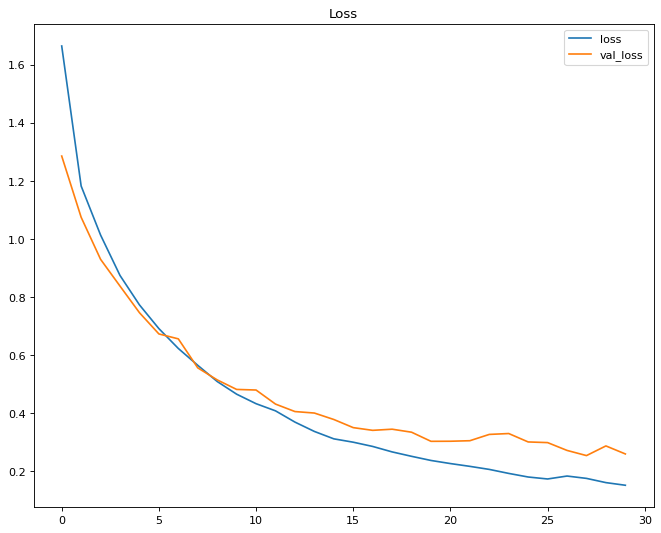

In [45]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

Text(0.5, 1.0, 'Acc')

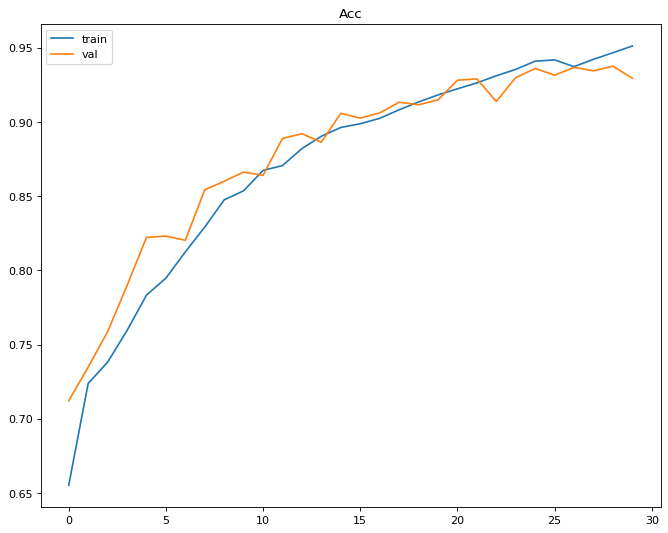

In [46]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history['crf_accuracy'], label='train')
plt.plot(history.history['val_crf_accuracy'], label='val')
plt.legend()
plt.title('Acc')

In [47]:
model.evaluate(x_test, y_test)

167/167 [==============================] - 0s 3ms/step


[0.36575810513096657, 0.9034597873687744]

In [48]:
pre = np.argmax(model.predict(text), axis=-1)

In [49]:
target_names = ['O', 'B_LOC', 'I_LOC', 'B_ORG', 'I_ORG', 'B_PRO', 'I_PRO', 'B_T', 'I_T']

In [50]:
print(classification_report(label.flatten(), pre.flatten(), target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

           O       0.97      0.98      0.97     35913
       B_LOC       0.81      0.49      0.61       775
       I_LOC       0.82      0.84      0.83      2789
       B_ORG       0.80      0.57      0.66       898
       I_ORG       0.90      0.93      0.91      5549
       B_PRO       0.98      0.70      0.82       186
       I_PRO       0.96      0.93      0.94      2344
         B_T       0.90      0.65      0.75       235
         I_T       0.91      0.94      0.92      1351

    accuracy                           0.94     50040
   macro avg       0.89      0.78      0.83     50040
weighted avg       0.94      0.94      0.94     50040



In [51]:
r_s = recall_score(label.flatten(), pre.flatten(), average=None)
p_s = precision_score(label.flatten(), pre.flatten(), average=None)
f_s = f1_score(label.flatten(), pre.flatten(), average=None)

In [52]:
radar_chart = pygal.Radar(fill=True, range=(0, 1))

radar_chart.title = '指标可视化'
radar_chart.x_labels = target_names

radar_chart.add('Recall', r_s)
radar_chart.add('Precision', p_s)
radar_chart.add('F1', f_s)
 
radar_chart.render_to_file('result1.svg')

In [53]:
text[0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  2,  3,
       17, 18,  6,  7,  8, 19,  6, 20, 21, 22,  8, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 11, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47,  6,  7,  8, 18, 48, 49])

In [54]:
pre[0]

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4], dtype=int64)

In [55]:
label[0]

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 7, 8, 8, 8, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4])

In [56]:
targ

{'O': 0,
 'B_LOC': 1,
 'I_LOC': 2,
 'B_ORG': 3,
 'I_ORG': 4,
 'B_PRO': 5,
 'I_PRO': 6,
 'B_T': 7,
 'I_T': 8}

In [57]:
def invert_dict(d):
    return dict([(v, k) for (k, v) in d.items()])

In [58]:
targ_idx = invert_dict(targ)
targ_idx

{0: 'O',
 1: 'B_LOC',
 2: 'I_LOC',
 3: 'B_ORG',
 4: 'I_ORG',
 5: 'B_PRO',
 6: 'I_PRO',
 7: 'B_T',
 8: 'I_T'}

In [59]:
# model.save_weights('model.h5')